# ArcGIS Notebooks Training 

## Introduction

The goal of this tutorial is to quantify that the progress the Philadelphia Parks & Recreation (PPR) tree mapping interns have been making (as of September 2021) in mapping every PPR-owned park tree (one point per tree) in the city. This analysis uses the accurate <a href="https://www.opendataphilly.org/dataset/ppr-tree-canopy/resource/83c75ba3-39f4-4e5c-9cbf-c7256c1dfb29">2018 canopy data</a> to measure park tree mapping progress. This entails estimating canopy size for all PPR-owned park and street tree points (using the DBH field) to measure against the 2018 canopy, excluding the street tree canopy from the analysis to ensure that only park tree canopy is being measured, and determining the percentage of completed park tree mapping per PPR property. This can then be used to determine which properties need additional evaluation/visits by the interns.

This tutorial uses arcpy, pandas, and ArcGIS API for Python.

## Getting started - Load libraries and set environment

In [8]:
import pandas as pd
import os

import arcgis
import arcpy

## Define the ArcGIS Pro project and workspace

In [9]:
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps('Map')[0] # first map in project - mine is titled "Map"

In [10]:
# Create a variable that represents the default file geodatabase
fgdb = r'X:\Users_GIS_Data\Gorey_Evelyn\eg_generic.gdb'

aprx.defaultGeodatabase = fgdb
arcpy.env.workspace = fgdb
arcpy.env.overwriteOutput=True

## Prepare layers by setting definition queries and defining boundaries

We only want tree canopy that currently exists rather than canopy that has been lost, so we will set a definition query to only include canopy that has been gained between 2008-2018 and canopy that has not changed between 2008-2018 (taken from our ```TreeCanopyChange_2008_2018``` layer).

In [11]:
for lyr in mp.listLayers("TreeCanopyChange_2008_2018"):
    lyr.definitionQuery = "Class_name = 'Gain' Or Class_name = 'No Change'" 
    # set definition query for tree canopy layer

We only want to examine the non-nested PPR properties, so we will set a definition query to only include non-nested properties (taken from our ```PPR_Properties``` layer).

In [12]:
for lyr in mp.listLayers("PPR_Properties"):
    lyr.definitionQuery = "NESTED = 'N'"

Some of the street tree and park tree features are not living trees (e.g., tree stumps are included in the dataset but should not be included in this analysis). We only want living trees, so we will set a definition query to only include features labeled <font color='teal'>TREE</font> in the <font color='teal'>ASSET_TYPE</font> field.

Because both the ``CW_PPR_Park_Trees`` and ``CW_PPR_Trees`` layers have the same field names, we can set the same definition query for both layers at one time.

In [13]:
for lyr in mp.listLayers():
    if lyr.name == "CW_PPR_Park_Trees" or lyr.name == "CW_PPR_Trees":
        lyr.definitionQuery = "ASSET_TYPE = 'TREE'"

## Make processing faster by including only features near or within the PPR properties

Let's use ArcPy to select only the street trees that are within 30 feet of the PPR Properties and then make this selection a layer in our map.

In [14]:
selection = arcpy.SelectLayerByLocation_management("CW_PPR_Trees", "WITHIN_A_DISTANCE", "PPR_Properties",
                                                     "30 Feet") # select all street trees within 30 feet of the properties

In [15]:
arcpy.CopyFeatures_management(selection, 'strtrees_30ft') # add this selection as a new layer to Pro

<Result 'X:\\Users_GIS_Data\\Gorey_Evelyn\\eg_generic.gdb\\strtrees_30ft'>

Check the map to see if the ``strtrees_30ft`` layer was added properly.

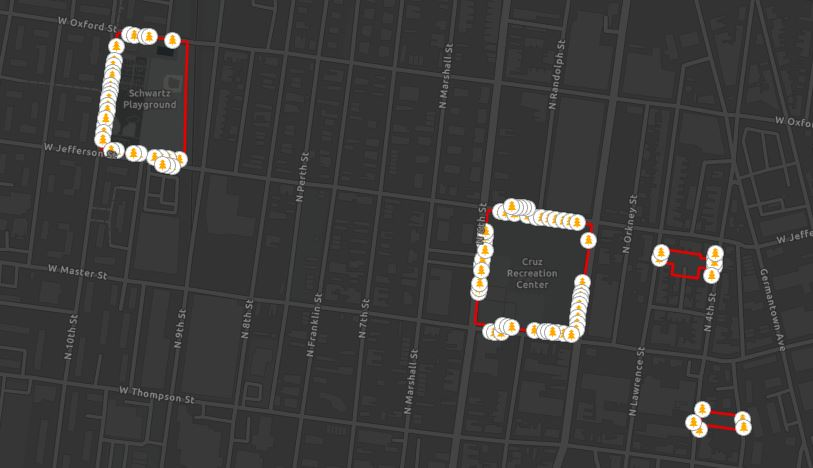

## Clip and dissolve the 2008-2018 canopy layer

Now let's define a function to speed up the clip/dissolve process. Instead of executing these steps separately, we can do it all at once while still using ArcPy. 

We have to create 2 layers in this process - ``clipped`` (which gets deleted) and ``clipdissolve`` - since ArcPy functions automatically create new output layers even if you do not specify a new layer name.

In [16]:
def clip_dissolve(x):
    """clips the input feature by PPR properties, dissolves the output, and deletes the original clipped layer"""
    arcpy.analysis.Clip(x, 'PPR_Properties', 'clipped')
    arcpy.management.Dissolve('clipped', 'clipdissolve_canopy')
    arcpy.Delete_management('clipped') # deletes it from the Contents pane only - to delete it from the gdb, provide the path:
    # arcpy.Delete_management(r'X:\Users_GIS_Data\Gorey_Evelyn\eg_generic.gdb\clipped')

Now we're going to run the function we just created. It will likely take a minute or two since the 2008-2018 canopy feature is a large one. Watch the Contents pane for the feature titled ``clipped`` that then gets deleted. Check your map after to ensure the output is what we actually wanted (canopy that is clipped to the parks and dissolved). 

<i>Note that the layer will only be removed from the Contents pane; if you want it to be removed from the geodatabase itself, the path would have to be specified in the ```arcpy.Delete_management()``` parameter instead of just the layer name.</i>

In [17]:
clip_dissolve('TreeCanopyChange_2008_2018')

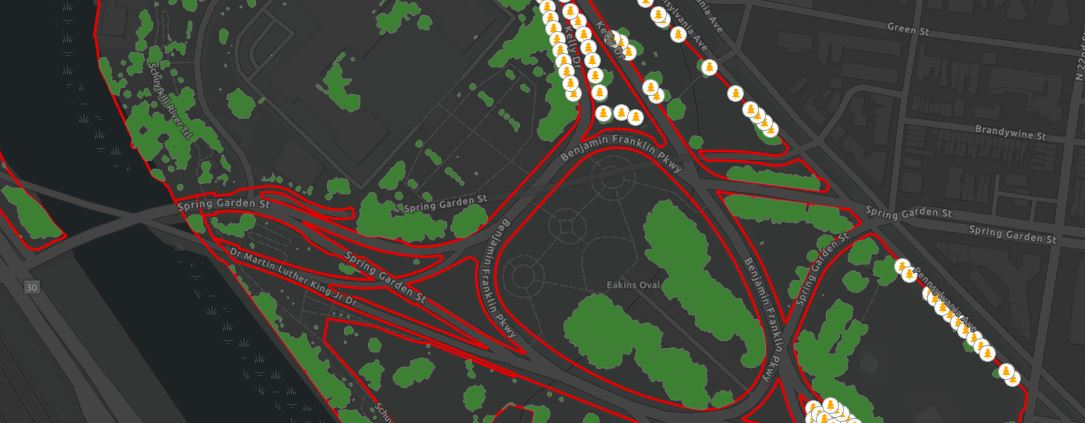

## Add a canopy size field for both PPR park trees and street trees

The formula to estimate canopy size from DBH came from the reverse of the formula found on the <a href="https://www.portland.gov/sites/default/files/2020-08/portland-tree-canopy-composition-gis-analysis-report-18june20.pdf">2020 City of Portland Tree Canopy Analysis Final Report</a>'s page 4, which estimates DBH using canopy. The formula was tweaked a bit to use in a buffer operation (dividing by 2 at the end).

In [18]:
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [19]:
# create spatial dataframes using pandas for the trees layers to easily add and edit fields
parktrees_sdf = pd.DataFrame.spatial.from_featureclass("CW_PPR_Park_Trees")
streettrees_sdf = pd.DataFrame.spatial.from_featureclass("strtrees_30ft")

In [20]:
parktrees_sdf.head(10) # preview the first ten features of one of the spatial dataframes

,OBJECTID,address_nu,street_nam,park_name,site_name,trail_name,additional,tree_name,tree_dbh,estcanopy_width,tree_condi,contract_c,contract_s,asset_type,overhead_u,undergroun,pit_type,pit_length,pit_width,grate,pathway_is,tree_heigh,tree_sprea,arborists_,cw_unique,global_id,creation_da,creator,edit_date,editor,council_di,st_tree_di,arborist_r,SHAPE
0,1,,,West Fairmount Park,Fairmount Park Horticulture Center,,,GINKGO BILOBA - GINKGO,36.0,32.261329,FAIR,,,TREE,NONE,N,,0.0,0.0,,,75.0,30.0,,,e8a1dc75-b22e-4f4b-a700-7f9c85effb9f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680038.0955506414, ""y"": 247195.87921981..."
1,2,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,0.0,0.000000,FAIR,,,TREE,,,,0.0,0.0,,,13.0,0.0,,,bd8b2d11-e906-4dbb-adc7-f1dc9cd0a500,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680030.4843453914, ""y"": 247163.16865530..."
2,3,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,8.0,6.634384,FAIR,,,TREE,,,,0.0,0.0,,,14.0,0.0,,,074c4ae0-f9be-4410-955a-97ad233d2741,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680065.8641958833, ""y"": 247169.67553205..."
3,4,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,12.0,10.295376,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,907f838c-baa1-4b29-b7b6-ac2fb057b625,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680008.573956132, ""y"": 247238.635039806..."
4,5,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PSEUDOPLATANUS - SYCAMORE MAPLE,17.0,14.871617,POOR,,,TREE,,,,0.0,0.0,,,20.0,15.0,,,a3e6928d-0dcd-450d-a8f3-485a39aa0e1f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680102.5990305543, ""y"": 247172.61548681..."
5,6,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ILEX OPACA - AMERICAN HOLLY,10.0,8.464880,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,db287025-2fe0-4215-afe1-0223a176773b,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680046.8153494745, ""y"": 247260.33840847..."
6,7,,,West Fairmount Park,Fairmount Park Horticulture Center,,,UNKNOWN UNKNOWN - UNKNOWN,32.0,28.600337,DEAD,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,f02b96d8-ff41-4608-a6ba-68ff4687008c,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680037.28256014, ""y"": 246850.1302393973..."
7,8,,,West Fairmount Park,Fairmount Park Horticulture Center,,,KOELREUTERIA PANICULATA - GOLDENRAIN TREE,25.0,22.193601,FAIR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,7e585b22-ac62-4a43-971b-574a51221556,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680155.846627474, ""y"": 247239.083529725..."
8,9,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has major problems,such as several severe...",CORNUS KOUSA - KOUSA DOGWOOD,17.0,14.871617,CRITICAL,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,82880928-5fda-4ec1-a5f7-f63eab614855,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680169.5103140473, ""y"": 247253.39058773..."
9,10,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has a bit of a lean to it, thus the poor ...",AMELANCHIER SPECIES - OTHER SERVICEBERRY,7.0,5.719136,POOR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,N,,8520973e-2062-4167-81ed-9309d4e4eda7,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680190.585731223, ""y"": 247219.174120724..."


In [21]:
streettrees_sdf.head(10) # preview the first ten features of the other spatial dataframe

,OBJECTID,ADDRESS_NU,STREET_NAM,ZIP_CODE,TREE_NUMBE,TREE_NAME,TREE_DBH,TREE_CONDI,CONTRACT_C,CONTRACT_S,ASSET_TYPE,OVERHEAD_U,UNDERGROUN,PIT_TYPE,PIT_LENGTH,PIT_WIDTH,GRATE,HOMEOWNER_,SIDEWALK_I,TREE_HEIGH,TREE_SPREA,CW_UNIQUE,GlobalID,CreationDa,Creator,EditDate,Editor,COUNCIL_DI,ST_TREE_DI,ARBORIST_R,X,Y,SHAPE
0,1,124,DIAMOND ST,19122,1,GINKGO BILOBA - GINKGO,14.0,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,46b3e5e9-9235-455c-a1d0-fa813f41bc20,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,7,1,S,2701431,247072,"{""x"": 2701430.7633951753, ""y"": 247072.03661975..."
1,2,200,S 6th St,19106,,GINKGO BILOBA - GINKGO,2.0,,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,d08c6430-3578-4277-ac0d-dd8e9b71a0f4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2697030,234440,"{""x"": 2697029.7495594174, ""y"": 234440.43655492..."
2,3,300,Shunk St,19148,3,GLEDITSIA TRIACANTHOS - HONEYLOCUST,18.0,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,1f55fb50-7439-402c-9398-fad09a26a607,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696642,222919,"{""x"": 2696642.3809115887, ""y"": 222919.04654000..."
3,4,617,N 18th ST,19130,1,PYRUS CALLERYANA - CALLERY PEAR,21.0,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,baeb4961-2aa8-408e-9dc5-24ea09c63aa4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2692382,241174,"{""x"": 2692381.705049753, ""y"": 241173.670791834..."
4,5,1801,Rittenhouse Sq,19103,2,ACER RUBRUM - RED MAPLE,5.0,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,ffb74410-84ec-464b-bf80-9d8d8be0de8a,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691387,234701,"{""x"": 2691386.7155699283, ""y"": 234700.77199225..."
5,6,1801,Rittenhouse Sq,19103,3,ACER RUBRUM - RED MAPLE,6.0,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,c5e0356d-e5fa-49c2-885d-a13e7bbf16ff,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691355,234702,"{""x"": 2691354.9872869253, ""y"": 234701.57087516..."
6,7,1801,Rittenhouse Sq,19103,4,SOPHORA JAPONICA - JAPANESE PAGODA TREE,6.0,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,629326c2-d5e9-49fc-985e-339a7cd01a0f,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691325,234706,"{""x"": 2691325.4325560033, ""y"": 234705.90715259..."
7,8,2601,S 4th St,19148,8,PLATANUS X ACERIFOLIA - LONDON PLANETREE,30.0,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,4c4df23b-dd37-4090-a0d8-8443d6217de8,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696362,222713,"{""x"": 2696362.283374667, ""y"": 222713.094524085..."
8,9,2601,S 4th St,19148,9,PLATANUS X ACERIFOLIA - LONDON PLANETREE,34.0,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,40f588a2-de84-4191-a8f7-fc2957cba2fd,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696358,222678,"{""x"": 2696358.0317427516, ""y"": 222678.48140433..."
9,10,3616,N MARVINE ST,19140,1,PLATANUS X ACERIFOLIA - LONDON PLANETREE,24.0,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,afa440ad-f696-4974-9b92-6fe5511dbcae,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,5,1,NW,2697584,256338,"{""x"": 2697583.8265352547, ""y"": 256337.73527991..."


In [24]:
val = ((parktrees_sdf.tree_dbh / 0.5463) - 1.3752) / 2 # setting the equation
parktrees_sdf.insert(9, 'estcanopy_width', value=val) # adding the field to go next to the original DBH field with the equation above as its value

In [25]:
parktrees_sdf.head(10) # check the results

,OBJECTID,address_nu,street_nam,park_name,site_name,trail_name,additional,tree_name,tree_dbh,estcanopy_width,tree_condi,contract_c,contract_s,asset_type,overhead_u,undergroun,pit_type,pit_length,pit_width,grate,pathway_is,tree_heigh,tree_sprea,arborists_,cw_unique,global_id,creation_da,creator,edit_date,editor,council_di,st_tree_di,arborist_r,SHAPE
0,1,,,West Fairmount Park,Fairmount Park Horticulture Center,,,GINKGO BILOBA - GINKGO,36.0,32.261329,FAIR,,,TREE,NONE,N,,0.0,0.0,,,75.0,30.0,,,e8a1dc75-b22e-4f4b-a700-7f9c85effb9f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680038.0955506414, ""y"": 247195.87921981..."
1,2,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,0.0,-0.687600,FAIR,,,TREE,,,,0.0,0.0,,,13.0,0.0,,,bd8b2d11-e906-4dbb-adc7-f1dc9cd0a500,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680030.4843453914, ""y"": 247163.16865530..."
2,3,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,8.0,6.634384,FAIR,,,TREE,,,,0.0,0.0,,,14.0,0.0,,,074c4ae0-f9be-4410-955a-97ad233d2741,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680065.8641958833, ""y"": 247169.67553205..."
3,4,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,12.0,10.295376,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,907f838c-baa1-4b29-b7b6-ac2fb057b625,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680008.573956132, ""y"": 247238.635039806..."
4,5,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PSEUDOPLATANUS - SYCAMORE MAPLE,17.0,14.871617,POOR,,,TREE,,,,0.0,0.0,,,20.0,15.0,,,a3e6928d-0dcd-450d-a8f3-485a39aa0e1f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680102.5990305543, ""y"": 247172.61548681..."
5,6,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ILEX OPACA - AMERICAN HOLLY,10.0,8.464880,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,db287025-2fe0-4215-afe1-0223a176773b,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680046.8153494745, ""y"": 247260.33840847..."
6,7,,,West Fairmount Park,Fairmount Park Horticulture Center,,,UNKNOWN UNKNOWN - UNKNOWN,32.0,28.600337,DEAD,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,f02b96d8-ff41-4608-a6ba-68ff4687008c,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680037.28256014, ""y"": 246850.1302393973..."
7,8,,,West Fairmount Park,Fairmount Park Horticulture Center,,,KOELREUTERIA PANICULATA - GOLDENRAIN TREE,25.0,22.193601,FAIR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,7e585b22-ac62-4a43-971b-574a51221556,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680155.846627474, ""y"": 247239.083529725..."
8,9,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has major problems,such as several severe...",CORNUS KOUSA - KOUSA DOGWOOD,17.0,14.871617,CRITICAL,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,82880928-5fda-4ec1-a5f7-f63eab614855,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680169.5103140473, ""y"": 247253.39058773..."
9,10,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has a bit of a lean to it, thus the poor ...",AMELANCHIER SPECIES - OTHER SERVICEBERRY,7.0,5.719136,POOR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,N,,8520973e-2062-4167-81ed-9309d4e4eda7,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680190.585731223, ""y"": 247219.174120724..."


In [26]:
val2 = ((streettrees_sdf.TREE_DBH / 0.5463) - 1.3752) / 2
streettrees_sdf.insert(7, 'estcanopy_width', value=val2)

In [27]:
streettrees_sdf.head(10) # check the results

,OBJECTID,ADDRESS_NU,STREET_NAM,ZIP_CODE,TREE_NUMBE,TREE_NAME,TREE_DBH,estcanopy_width,TREE_CONDI,CONTRACT_C,CONTRACT_S,ASSET_TYPE,OVERHEAD_U,UNDERGROUN,PIT_TYPE,PIT_LENGTH,PIT_WIDTH,GRATE,HOMEOWNER_,SIDEWALK_I,TREE_HEIGH,TREE_SPREA,CW_UNIQUE,GlobalID,CreationDa,Creator,EditDate,Editor,COUNCIL_DI,ST_TREE_DI,ARBORIST_R,X,Y,SHAPE
0,1,124,DIAMOND ST,19122,1,GINKGO BILOBA - GINKGO,14.0,12.125872,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,46b3e5e9-9235-455c-a1d0-fa813f41bc20,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,7,1,S,2701431,247072,"{""x"": 2701430.7633951753, ""y"": 247072.03661975..."
1,2,200,S 6th St,19106,,GINKGO BILOBA - GINKGO,2.0,1.142896,,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,d08c6430-3578-4277-ac0d-dd8e9b71a0f4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2697030,234440,"{""x"": 2697029.7495594174, ""y"": 234440.43655492..."
2,3,300,Shunk St,19148,3,GLEDITSIA TRIACANTHOS - HONEYLOCUST,18.0,15.786865,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,1f55fb50-7439-402c-9398-fad09a26a607,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696642,222919,"{""x"": 2696642.3809115887, ""y"": 222919.04654000..."
3,4,617,N 18th ST,19130,1,PYRUS CALLERYANA - CALLERY PEAR,21.0,18.532609,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,baeb4961-2aa8-408e-9dc5-24ea09c63aa4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2692382,241174,"{""x"": 2692381.705049753, ""y"": 241173.670791834..."
4,5,1801,Rittenhouse Sq,19103,2,ACER RUBRUM - RED MAPLE,5.0,3.888640,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,ffb74410-84ec-464b-bf80-9d8d8be0de8a,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691387,234701,"{""x"": 2691386.7155699283, ""y"": 234700.77199225..."
5,6,1801,Rittenhouse Sq,19103,3,ACER RUBRUM - RED MAPLE,6.0,4.803888,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,c5e0356d-e5fa-49c2-885d-a13e7bbf16ff,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691355,234702,"{""x"": 2691354.9872869253, ""y"": 234701.57087516..."
6,7,1801,Rittenhouse Sq,19103,4,SOPHORA JAPONICA - JAPANESE PAGODA TREE,6.0,4.803888,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,629326c2-d5e9-49fc-985e-339a7cd01a0f,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691325,234706,"{""x"": 2691325.4325560033, ""y"": 234705.90715259..."
7,8,2601,S 4th St,19148,8,PLATANUS X ACERIFOLIA - LONDON PLANETREE,30.0,26.769841,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,4c4df23b-dd37-4090-a0d8-8443d6217de8,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696362,222713,"{""x"": 2696362.283374667, ""y"": 222713.094524085..."
8,9,2601,S 4th St,19148,9,PLATANUS X ACERIFOLIA - LONDON PLANETREE,34.0,30.430833,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,40f588a2-de84-4191-a8f7-fc2957cba2fd,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696358,222678,"{""x"": 2696358.0317427516, ""y"": 222678.48140433..."
9,10,3616,N MARVINE ST,19140,1,PLATANUS X ACERIFOLIA - LONDON PLANETREE,24.0,21.278353,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,afa440ad-f696-4974-9b92-6fe5511dbcae,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,5,1,NW,2697584,256338,"{""x"": 2697583.8265352547, ""y"": 256337.73527991..."


Negative or NA values won't work properly when buffering to create an estimated canopy feature, so we're going to fill NAs and negative values with 0.

In [28]:
def fillnazero(x):
    x[['estcanopy_width']] = x[['estcanopy_width']].fillna(0) # replace all NA values in the new field with 0
    x.loc[(x.estcanopy_width < 0), 'estcanopy_width'] = 0 # replace all negative values in the new field with 0

In [29]:
tree_sdfs = [parktrees_sdf, streettrees_sdf] # creating a list for both dataframes to make the fillnazero() function apply to both at once

for tree_sdf in tree_sdfs:
    fillnazero(tree_sdf)

In [30]:
parktrees_sdf.head(10) # check the results

,OBJECTID,address_nu,street_nam,park_name,site_name,trail_name,additional,tree_name,tree_dbh,estcanopy_width,tree_condi,contract_c,contract_s,asset_type,overhead_u,undergroun,pit_type,pit_length,pit_width,grate,pathway_is,tree_heigh,tree_sprea,arborists_,cw_unique,global_id,creation_da,creator,edit_date,editor,council_di,st_tree_di,arborist_r,SHAPE
0,1,,,West Fairmount Park,Fairmount Park Horticulture Center,,,GINKGO BILOBA - GINKGO,36.0,32.261329,FAIR,,,TREE,NONE,N,,0.0,0.0,,,75.0,30.0,,,e8a1dc75-b22e-4f4b-a700-7f9c85effb9f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680038.0955506414, ""y"": 247195.87921981..."
1,2,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,0.0,0.000000,FAIR,,,TREE,,,,0.0,0.0,,,13.0,0.0,,,bd8b2d11-e906-4dbb-adc7-f1dc9cd0a500,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680030.4843453914, ""y"": 247163.16865530..."
2,3,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,8.0,6.634384,FAIR,,,TREE,,,,0.0,0.0,,,14.0,0.0,,,074c4ae0-f9be-4410-955a-97ad233d2741,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680065.8641958833, ""y"": 247169.67553205..."
3,4,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PALMATUM - JAPANESE MAPLE,12.0,10.295376,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,907f838c-baa1-4b29-b7b6-ac2fb057b625,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680008.573956132, ""y"": 247238.635039806..."
4,5,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ACER PSEUDOPLATANUS - SYCAMORE MAPLE,17.0,14.871617,POOR,,,TREE,,,,0.0,0.0,,,20.0,15.0,,,a3e6928d-0dcd-450d-a8f3-485a39aa0e1f,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680102.5990305543, ""y"": 247172.61548681..."
5,6,,,West Fairmount Park,Fairmount Park Horticulture Center,,,ILEX OPACA - AMERICAN HOLLY,10.0,8.464880,FAIR,,,TREE,,,,0.0,0.0,,,25.0,20.0,,,db287025-2fe0-4215-afe1-0223a176773b,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680046.8153494745, ""y"": 247260.33840847..."
6,7,,,West Fairmount Park,Fairmount Park Horticulture Center,,,UNKNOWN UNKNOWN - UNKNOWN,32.0,28.600337,DEAD,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,f02b96d8-ff41-4608-a6ba-68ff4687008c,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680037.28256014, ""y"": 246850.1302393973..."
7,8,,,West Fairmount Park,Fairmount Park Horticulture Center,,,KOELREUTERIA PANICULATA - GOLDENRAIN TREE,25.0,22.193601,FAIR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,7e585b22-ac62-4a43-971b-574a51221556,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680155.846627474, ""y"": 247239.083529725..."
8,9,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has major problems,such as several severe...",CORNUS KOUSA - KOUSA DOGWOOD,17.0,14.871617,CRITICAL,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,,,82880928-5fda-4ec1-a5f7-f63eab614855,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680169.5103140473, ""y"": 247253.39058773..."
9,10,,,West Fairmount Park,Fairmount Park Horticulture Center,,"Tree has a bit of a lean to it, thus the poor ...",AMELANCHIER SPECIES - OTHER SERVICEBERRY,7.0,5.719136,POOR,,,TREE,NONE,N,,0.0,0.0,,,0.0,0.0,N,,8520973e-2062-4167-81ed-9309d4e4eda7,2021-06-24,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,4,4,S,"{""x"": 2680190.585731223, ""y"": 247219.174120724..."


In [31]:
streettrees_sdf.head(10)

,OBJECTID,ADDRESS_NU,STREET_NAM,ZIP_CODE,TREE_NUMBE,TREE_NAME,TREE_DBH,estcanopy_width,TREE_CONDI,CONTRACT_C,CONTRACT_S,ASSET_TYPE,OVERHEAD_U,UNDERGROUN,PIT_TYPE,PIT_LENGTH,PIT_WIDTH,GRATE,HOMEOWNER_,SIDEWALK_I,TREE_HEIGH,TREE_SPREA,CW_UNIQUE,GlobalID,CreationDa,Creator,EditDate,Editor,COUNCIL_DI,ST_TREE_DI,ARBORIST_R,X,Y,SHAPE
0,1,124,DIAMOND ST,19122,1,GINKGO BILOBA - GINKGO,14.0,12.125872,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,46b3e5e9-9235-455c-a1d0-fa813f41bc20,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,7,1,S,2701431,247072,"{""x"": 2701430.7633951753, ""y"": 247072.03661975..."
1,2,200,S 6th St,19106,,GINKGO BILOBA - GINKGO,2.0,1.142896,,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,d08c6430-3578-4277-ac0d-dd8e9b71a0f4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2697030,234440,"{""x"": 2697029.7495594174, ""y"": 234440.43655492..."
2,3,300,Shunk St,19148,3,GLEDITSIA TRIACANTHOS - HONEYLOCUST,18.0,15.786865,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,1f55fb50-7439-402c-9398-fad09a26a607,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696642,222919,"{""x"": 2696642.3809115887, ""y"": 222919.04654000..."
3,4,617,N 18th ST,19130,1,PYRUS CALLERYANA - CALLERY PEAR,21.0,18.532609,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,baeb4961-2aa8-408e-9dc5-24ea09c63aa4,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2692382,241174,"{""x"": 2692381.705049753, ""y"": 241173.670791834..."
4,5,1801,Rittenhouse Sq,19103,2,ACER RUBRUM - RED MAPLE,5.0,3.888640,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,ffb74410-84ec-464b-bf80-9d8d8be0de8a,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691387,234701,"{""x"": 2691386.7155699283, ""y"": 234700.77199225..."
5,6,1801,Rittenhouse Sq,19103,3,ACER RUBRUM - RED MAPLE,6.0,4.803888,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,c5e0356d-e5fa-49c2-885d-a13e7bbf16ff,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691355,234702,"{""x"": 2691354.9872869253, ""y"": 234701.57087516..."
6,7,1801,Rittenhouse Sq,19103,4,SOPHORA JAPONICA - JAPANESE PAGODA TREE,6.0,4.803888,FAIR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,629326c2-d5e9-49fc-985e-339a7cd01a0f,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,5,2,S,2691325,234706,"{""x"": 2691325.4325560033, ""y"": 234705.90715259..."
7,8,2601,S 4th St,19148,8,PLATANUS X ACERIFOLIA - LONDON PLANETREE,30.0,26.769841,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,4c4df23b-dd37-4090-a0d8-8443d6217de8,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696362,222713,"{""x"": 2696362.283374667, ""y"": 222713.094524085..."
8,9,2601,S 4th St,19148,9,PLATANUS X ACERIFOLIA - LONDON PLANETREE,34.0,30.430833,POOR,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,40f588a2-de84-4191-a8f7-fc2957cba2fd,2021-01-22,Chris.Park@phila.gov_phl,2021-09-21,Chris.Park@phila.gov_phl,1,2,S,2696358,222678,"{""x"": 2696358.0317427516, ""y"": 222678.48140433..."
9,10,3616,N MARVINE ST,19140,1,PLATANUS X ACERIFOLIA - LONDON PLANETREE,24.0,21.278353,OVERGROWN,,,TREE,,,,0.0,0.0,,,,0.0,0.0,,afa440ad-f696-4974-9b92-6fe5511dbcae,2021-01-22,Chris.Park@phila.gov_phl,2021-09-20,Chris.Park@phila.gov_phl,5,1,NW,2697584,256338,"{""x"": 2697583.8265352547, ""y"": 256337.73527991..."


In [23]:
# parktrees_sdf = parktrees_sdf.drop(['estcanopy_width'], axis=1) #if needing to delete a column

Now we're going to have to bring these dataframes back to spatial layers that can replace our previous versions that don't have our new estimated canopy size field. 

In [32]:
streettrees_sdf.spatial.to_featureclass(location=r'X:\Users_GIS_Data\Gorey_Evelyn\eg_generic.gdb\strtrees_30ft', overwrite=True)

'X:\\Users_GIS_Data\\Gorey_Evelyn\\eg_generic.gdb\\strtrees_30ft'

In [33]:
parktrees_sdf.spatial.to_featureclass(location=r'X:\Users_GIS_Data\Gorey_Evelyn\eg_generic.gdb\parktrees', overwrite=True)

'X:\\Users_GIS_Data\\Gorey_Evelyn\\eg_generic.gdb\\parktrees'

<b><font color='red'>NOTE: Automatically locks the layer with the geometry not showing up on the map until another cell is run.</font></b>

## Buffer to Get an Estimated Canopy Size

Using our new estimated canopy fields, we can use the buffer tool to create these canopy features for both the park trees and the street trees. 

In [34]:
trees = ['parktrees', 'strtrees_30ft']
for tree in trees:
    arcpy.Buffer_analysis(tree, str(tree) + "_Buffer", "estcanopy_width") # buffer both tree features by the canopy field

The arcpy buffer and dissolve functions don't allow overwrites/write new outputs automatically (that I know of), so we need to write new features and remove the older, unnecessary features from the map for organization.

In [35]:
buffers = ['strtrees_30ft_Buffer', 'parktrees_Buffer']
for buffer in buffers:
    arcpy.management.Dissolve(buffer, str(buffer) + "Dissolve") # dissolves both buffer layers separately
for buffer in buffers:
    arcpy.Delete_management(buffer) # removes both buffer layers (before being dissolved) from the map to keep the contents pane clean

The results (shown below with the blue being the park trees' estimated canopy and the green being the 2018 canopy) are fairly accurate. They could be made more accurate by clipping the estimated canopy to better match the 2018 canopy and by removing street tree canopy, which is part of our next step.

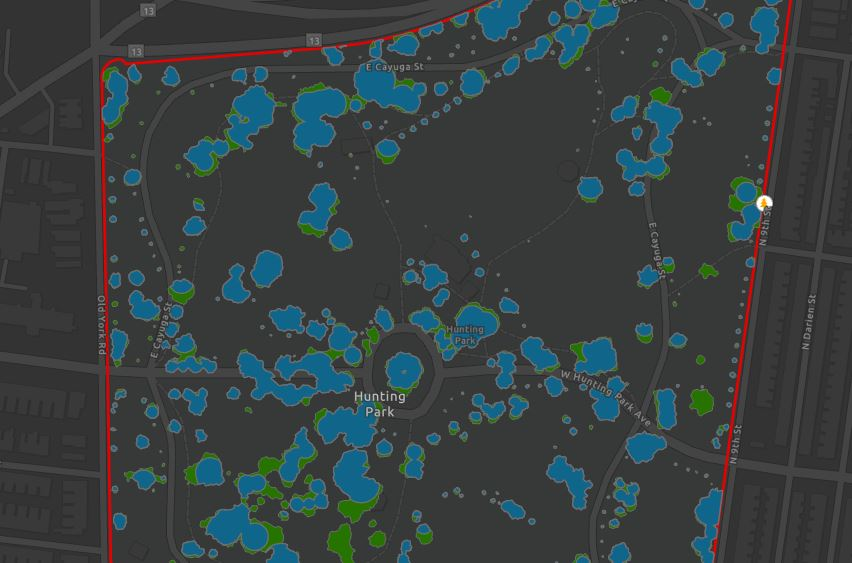

## Exclude Street Tree Canopy from the Estimated Park Tree Canopy

In [36]:
estcanopies = ['parktrees_BufferDissolve', 'strtrees_30ft_BufferDissolve'] # creating a list containing both estimated canopy layers

We're going to clip our estimated street and park tree canopy layers by the 2018 canopy for more accuracy.

In [37]:
for estcanopy in estcanopies:
    arcpy.analysis.Clip(estcanopy, 'clipdissolve_canopy', str(estcanopy) + "Clipped") # clipping the canopy layers by the 2008-2018 canopy to ensure accuracy

We're going to erase our estimated street tree canopy from the 2018 canopy so that the street tree canopy will not be included in our calculation, as we are only looking at the progress of park tree mapping.

In [38]:
arcpy.analysis.Erase('clipdissolve_canopy', 'strtrees_30ft_BufferDissolveClipped', 'canopy2018_nostr') # erasing the street tree canopy from the 2008-2018 canopy to remove street trees from the analysis

<Result 'X:\\Users_GIS_Data\\Gorey_Evelyn\\eg_generic.gdb\\canopy2018_nostr'>

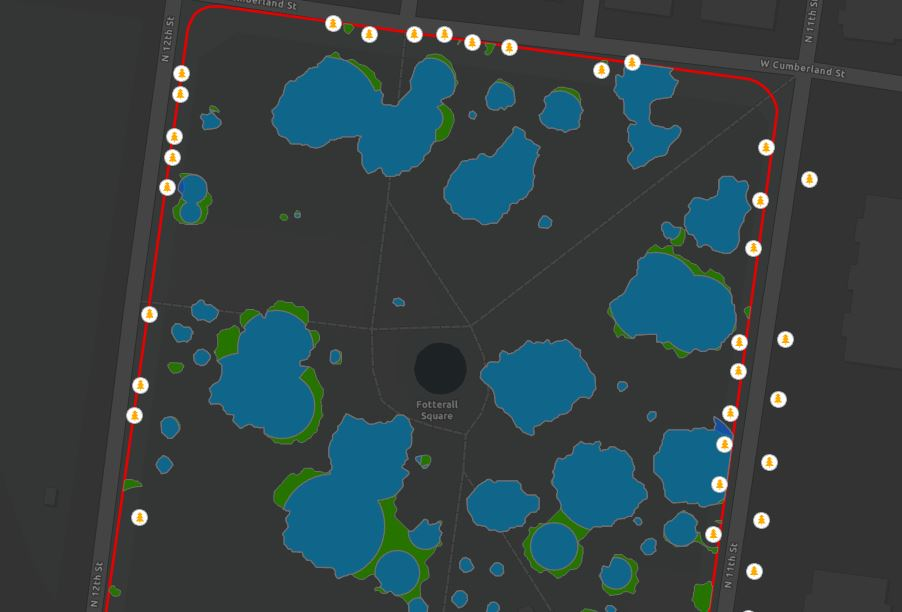

In [39]:
deletes = ['clipdissolve_canopy', 'strtrees_30ft_BufferDissolveClipped', 'parktrees_BufferDissolve', 'strtrees_30ft_BufferDissolve']
for delete in deletes:
    arcpy.Delete_management(delete)

## Comparing Canopy & Evaluating Each PPR Property

In [40]:
canopies = ['canopy2018_nostr', 'parktrees_BufferDissolveClipped']

Using the Summarize Within tool, we are now going compare the 2018 canopy within each PPR property and the estimated park tree canopy within each PPR property. Our goal is to have a field for both measurements in the same table so that we can calculate the percentage of mapped park trees, with the 2018 canopy as the denonimator.

In [41]:
for canopy in canopies:
    arcpy.analysis.SummarizeWithin('PPR_Properties', canopy, "Properties_" + str(canopy), shape_unit='SQUAREFEET')

In [43]:
canopy2018sum_sdf = pd.DataFrame.spatial.from_featureclass("Properties_canopy2018_nostr")
ptcanopysum_sdf = pd.DataFrame.spatial.from_featureclass("Properties_parktrees_BufferDissolveClipped")

In [44]:
ptcanopysum_sdf.head(10)

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,OFFICIAL_NAME_SOURCE,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,ADDRESS_BRT,ALIAS_ADDRESS,ACREAGE,PROPERTY_CLASSIFICATION,PPR_USE,MAINTENANCE,LAND_OWNERSHIP,TENANT,ACQUISITION_DATE,FORMER_DEPARTMENT,PPR_DISTRICT,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,GIS_CHRONOLOGY,DATE_EDITED,EDITED_BY,NOTES,sum_Area_SQUAREFEET,Polygon_Count,SHAPE
0,1,Schuylkill Banks,Schuylkill Banks,N,,,Schuylkill Banks,Schuylkill River Park,2794,400 S TANEY ST,19103,,400-16 S TANEY ST,14.717314,NEIGHBORHOOD_PARK,GREENWAY_PARKWAY,PPR,CITY,,1966,FPC,7,"5, 7","2, 5","9, 17",Y,Y,N,Bill 160113 (4/14/16) -South of South St Bridge,2017,2021-06-11,PARK_C,Feature Redesign Part 1,4.989615e+04,1,"{""rings"": [[[2688508.4060378373, 240072.395435..."
1,2,Schuylkill River Park,Schuylkill River Park,N,,,Schuylkill River Park,,2992,400 S TANEY ST,19146,"400-16 S TANEY ST, 338-46 S 26TH ST, 300 S 26T...","Pine & Taney;400-16 S TANEY ST, 338-46 S 26TH ...",7.327000,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,CITY,,1966,REC,7,"5, 7",2,9,Y,Y,N,,2017,2020-03-20,PARK_C,Feature Redesign Part 1,4.829469e+04,1,"{""curveRings"": [[[2688594.9120984226, 234593.7..."
2,3,Frankford Boat Launch,Frankford Boat Launch,N,Frankford Boat Launch,2019 - DF Research,Frankford Boat Launch,PA Fish & Boat;Frankford Arsenal Boat Launch,3090,5625 TACONY ST,19137,5625 TACONY ST,5650 Tacony St,11.369775,NEIGHBORHOOD_PARK,BOATHOUSE_LAUNCH,PPR,CITY,,2014,PPR,2,2,6,15,Y,Y,N,,2017,2021-01-04,PARK_C,Feature Redesign Part 1,2.400226e+04,1,"{""curveRings"": [[[2723063.984564334, 257098.14..."
3,4,Orthodox Street Park,Orthodox Street Park,N,,,Orthodox,Orthodox Street Parcel; Bridesburg Riverfront ...,3091,3101 ORTHODOX ST,19137,3101 ORTHODOX ST,,10.567379,NEIGHBORHOOD_PARK,UNDEVELOPED,PPR,CITY,,2019,OTHER,5,2,6,15,Y,N,N,Officially acquired from PAID in 10/2019. Doc ...,2017,2021-06-08,HUANG_M,Land acquired from PAID (10/2019). LWCF restri...,1.003586e+04,1,"{""curveRings"": [[[2720145.0310846716, 250656.8..."
4,5,Wissahickon Valley Park,Wissahickon Valley Park,N,Wissahickon Valley Park,Archives,Wissahickon Valley Park,,1357,,19128,,,2064.125834,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1867,FPC,4,4,"4, 8","5, 14, 39",Y,Y,N,,2017,2020-01-17,PARK_C,Feature Redesign Part 1,1.034045e+06,1,"{""curveRings"": [[[2681045.8829051703, 263442.2..."
5,6,West Fairmount Park,West Fairmount Park,N,West Fairmount Park,Archives,West Fairmount Park,,1714,,19131,3401 W GIRARD AVE,3401 W GIRARD AVE,1269.287285,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1866,FPC,7,5,"3, 4","16, 19",Y,Y,N,,2017,2020-01-07,PARK_C,Feature Redesign Part 1,2.810730e+06,1,"{""curveRings"": [[[2684140.7362955064, 244070.0..."
6,7,Pennypack Park,Pennypack Park,N,Pennypack Park,Archives,Pennypack Park,Little City (Near Rhawn St),1651,,19152,,,1367.419219,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1905-1929,FPC,1,1,"6, 10","7, 8, 15",Y,Y,N,,2017,2020-05-22,PARK_C,Feature Redesign Part 1,4.803338e+05,1,"{""rings"": [[[2724856.429470256, 271897.7602621..."
7,8,East Fairmount Park,East Fairmount Park,N,East Fairmount Park,Archives,East Fairmount Park,,1713,,19121,2500 SPRING GARDEN ST;3300 N 33RD ST,2500 SPRING GARDEN ST;3300 N 33RD ST,649.685022,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1844,FPC,7,5,"4, 5","5, 9, 22, 39",Y,Y,N,,2017,2021-03-26,PARK_C,Feature Redesign Part 1,2.363362e+06,1,"{""curveRings"": [[[2686240.6589329243, 244327.0..."
8,9,Tacony Creek Park,Tacony Creek Park,N,Tacony Creek Park,Archives,Tacony Creek Park,Brookwood Park,1961,,19120,,,316.739577,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1915,FPC,3,3,"7, 9","2, 15, 24, 25, 35",Y,Y,N,,2017,2021-05-17,PARK_C,Feature Redesign Part 1,1.284384e+06,1,"{""rings"": [[[2709875.6369253397, 260808.788017..."
9,10,Franklin Delano Roosevelt Park,Franklin Delano Roosevelt Park,N,Franklin Delano Roosevelt (FDR) Par

We want to make the canopy area columns different names so that they are easily distinguishable when in the same table.

In [45]:
canopy2018sum_sdf.rename(columns={'sum_Area_SQUAREFEET': 'sum_2018canopy'}, inplace=True)
ptcanopysum_sdf.rename(columns={'sum_Area_SQUAREFEET': 'sum_PPRparkcanopy'}, inplace=True)

For a more organized table, we do not want duplicate columns. The code block keeps all columns for the first spatial dataframe and only adds the new canopy area column for the second.

In [46]:
Propertysum_joined_sdf = ptcanopysum_sdf.merge(canopy2018sum_sdf, left_index=True, right_index=True, how='outer',
                                          suffixes=('', '_y'))
Propertysum_joined_sdf.drop(Propertysum_joined_sdf.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [47]:
Propertysum_joined_sdf.head(10)

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,OFFICIAL_NAME_SOURCE,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,ADDRESS_BRT,ALIAS_ADDRESS,ACREAGE,PROPERTY_CLASSIFICATION,PPR_USE,MAINTENANCE,LAND_OWNERSHIP,TENANT,ACQUISITION_DATE,FORMER_DEPARTMENT,PPR_DISTRICT,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,GIS_CHRONOLOGY,DATE_EDITED,EDITED_BY,NOTES,sum_PPRparkcanopy,Polygon_Count,SHAPE,sum_2018canopy
0,1,Schuylkill Banks,Schuylkill Banks,N,,,Schuylkill Banks,Schuylkill River Park,2794,400 S TANEY ST,19103,,400-16 S TANEY ST,14.717314,NEIGHBORHOOD_PARK,GREENWAY_PARKWAY,PPR,CITY,,1966,FPC,7,"5, 7","2, 5","9, 17",Y,Y,N,Bill 160113 (4/14/16) -South of South St Bridge,2017,2021-06-11,PARK_C,Feature Redesign Part 1,4.989615e+04,1,"{""rings"": [[[2688508.4060378373, 240072.395435...",1.076987e+05
1,2,Schuylkill River Park,Schuylkill River Park,N,,,Schuylkill River Park,,2992,400 S TANEY ST,19146,"400-16 S TANEY ST, 338-46 S 26TH ST, 300 S 26T...","Pine & Taney;400-16 S TANEY ST, 338-46 S 26TH ...",7.327000,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,CITY,,1966,REC,7,"5, 7",2,9,Y,Y,N,,2017,2020-03-20,PARK_C,Feature Redesign Part 1,4.829469e+04,1,"{""curveRings"": [[[2688594.9120984226, 234593.7...",1.032860e+05
2,3,Frankford Boat Launch,Frankford Boat Launch,N,Frankford Boat Launch,2019 - DF Research,Frankford Boat Launch,PA Fish & Boat;Frankford Arsenal Boat Launch,3090,5625 TACONY ST,19137,5625 TACONY ST,5650 Tacony St,11.369775,NEIGHBORHOOD_PARK,BOATHOUSE_LAUNCH,PPR,CITY,,2014,PPR,2,2,6,15,Y,Y,N,,2017,2021-01-04,PARK_C,Feature Redesign Part 1,2.400226e+04,1,"{""curveRings"": [[[2723063.984564334, 257098.14...",4.552709e+04
3,4,Orthodox Street Park,Orthodox Street Park,N,,,Orthodox,Orthodox Street Parcel; Bridesburg Riverfront ...,3091,3101 ORTHODOX ST,19137,3101 ORTHODOX ST,,10.567379,NEIGHBORHOOD_PARK,UNDEVELOPED,PPR,CITY,,2019,OTHER,5,2,6,15,Y,N,N,Officially acquired from PAID in 10/2019. Doc ...,2017,2021-06-08,HUANG_M,Land acquired from PAID (10/2019). LWCF restri...,1.003586e+04,1,"{""curveRings"": [[[2720145.0310846716, 250656.8...",9.642879e+04
4,5,Wissahickon Valley Park,Wissahickon Valley Park,N,Wissahickon Valley Park,Archives,Wissahickon Valley Park,,1357,,19128,,,2064.125834,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1867,FPC,4,4,"4, 8","5, 14, 39",Y,Y,N,,2017,2020-01-17,PARK_C,Feature Redesign Part 1,1.034045e+06,1,"{""curveRings"": [[[2681045.8829051703, 263442.2...",7.538076e+07
5,6,West Fairmount Park,West Fairmount Park,N,West Fairmount Park,Archives,West Fairmount Park,,1714,,19131,3401 W GIRARD AVE,3401 W GIRARD AVE,1269.287285,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1866,FPC,7,5,"3, 4","16, 19",Y,Y,N,,2017,2020-01-07,PARK_C,Feature Redesign Part 1,2.810730e+06,1,"{""curveRings"": [[[2684140.7362955064, 244070.0...",3.189753e+07
6,7,Pennypack Park,Pennypack Park,N,Pennypack Park,Archives,Pennypack Park,Little City (Near Rhawn St),1651,,19152,,,1367.419219,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1905-1929,FPC,1,1,"6, 10","7, 8, 15",Y,Y,N,,2017,2020-05-22,PARK_C,Feature Redesign Part 1,4.803338e+05,1,"{""rings"": [[[2724856.429470256, 271897.7602621...",4.955311e+07
7,8,East Fairmount Park,East Fairmount Park,N,East Fairmount Park,Archives,East Fairmount Park,,1713,,19121,2500 SPRING GARDEN ST;3300 N 33RD ST,2500 SPRING GARDEN ST;3300 N 33RD ST,649.685022,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1844,FPC,7,5,"4, 5","5, 9, 22, 39",Y,Y,N,,2017,2021-03-26,PARK_C,Feature Redesign Part 1,2.363362e+06,1,"{""curveRings"": [[[2686240.6589329243, 244327.0...",1.108937e+07
8,9,Tacony Creek Park,Tacony Creek Park,N,Tacony Creek Park,Archives,Tacony Creek Park,Brookwood Park,1961,,19120,,,316.739577,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1915,FPC,3,3,"7, 9","2, 15, 24, 25, 35",Y,Y,N,,2017,2021-05-17,PARK_C,Feature Redesign Part 1,1.284384e+06,1,"{""rings"": [[[2709875.6369253397, 26080

Now we need to measure mapping progress by dividing the estimated mapped park tree canopy by the 2018 canopy. This gives us the percentage of mapped park tree canopy per PPR property.

In [48]:
val3 = ((Propertysum_joined_sdf.sum_PPRparkcanopy / Propertysum_joined_sdf.sum_2018canopy) * 100)
Propertysum_joined_sdf.insert(len(Propertysum_joined_sdf.columns), 'perc_mapped', value=val3) # insert the percentage mapped column at the end of the table

In [49]:
Propertysum_joined_sdf.head(50)

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,OFFICIAL_NAME_SOURCE,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,ADDRESS_BRT,ALIAS_ADDRESS,ACREAGE,PROPERTY_CLASSIFICATION,PPR_USE,MAINTENANCE,LAND_OWNERSHIP,TENANT,ACQUISITION_DATE,FORMER_DEPARTMENT,PPR_DISTRICT,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,GIS_CHRONOLOGY,DATE_EDITED,EDITED_BY,NOTES,sum_PPRparkcanopy,Polygon_Count,SHAPE,sum_2018canopy,perc_mapped
0,1,Schuylkill Banks,Schuylkill Banks,N,,,Schuylkill Banks,Schuylkill River Park,2794,400 S TANEY ST,19103,,400-16 S TANEY ST,14.717314,NEIGHBORHOOD_PARK,GREENWAY_PARKWAY,PPR,CITY,,1966,FPC,7,"5, 7","2, 5","9, 17",Y,Y,N,Bill 160113 (4/14/16) -South of South St Bridge,2017,2021-06-11,PARK_C,Feature Redesign Part 1,4.989615e+04,1,"{""rings"": [[[2688508.4060378373, 240072.395435...",1.076987e+05,46.329406
1,2,Schuylkill River Park,Schuylkill River Park,N,,,Schuylkill River Park,,2992,400 S TANEY ST,19146,"400-16 S TANEY ST, 338-46 S 26TH ST, 300 S 26T...","Pine & Taney;400-16 S TANEY ST, 338-46 S 26TH ...",7.327000,NEIGHBORHOOD_PARK,RECREATION_SITE,PPR,CITY,,1966,REC,7,"5, 7",2,9,Y,Y,N,,2017,2020-03-20,PARK_C,Feature Redesign Part 1,4.829469e+04,1,"{""curveRings"": [[[2688594.9120984226, 234593.7...",1.032860e+05,46.758214
2,3,Frankford Boat Launch,Frankford Boat Launch,N,Frankford Boat Launch,2019 - DF Research,Frankford Boat Launch,PA Fish & Boat;Frankford Arsenal Boat Launch,3090,5625 TACONY ST,19137,5625 TACONY ST,5650 Tacony St,11.369775,NEIGHBORHOOD_PARK,BOATHOUSE_LAUNCH,PPR,CITY,,2014,PPR,2,2,6,15,Y,Y,N,,2017,2021-01-04,PARK_C,Feature Redesign Part 1,2.400226e+04,1,"{""curveRings"": [[[2723063.984564334, 257098.14...",4.552709e+04,52.720836
3,4,Orthodox Street Park,Orthodox Street Park,N,,,Orthodox,Orthodox Street Parcel; Bridesburg Riverfront ...,3091,3101 ORTHODOX ST,19137,3101 ORTHODOX ST,,10.567379,NEIGHBORHOOD_PARK,UNDEVELOPED,PPR,CITY,,2019,OTHER,5,2,6,15,Y,N,N,Officially acquired from PAID in 10/2019. Doc ...,2017,2021-06-08,HUANG_M,Land acquired from PAID (10/2019). LWCF restri...,1.003586e+04,1,"{""curveRings"": [[[2720145.0310846716, 250656.8...",9.642879e+04,10.407535
4,5,Wissahickon Valley Park,Wissahickon Valley Park,N,Wissahickon Valley Park,Archives,Wissahickon Valley Park,,1357,,19128,,,2064.125834,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1867,FPC,4,4,"4, 8","5, 14, 39",Y,Y,N,,2017,2020-01-17,PARK_C,Feature Redesign Part 1,1.034045e+06,1,"{""curveRings"": [[[2681045.8829051703, 263442.2...",7.538076e+07,1.371762
5,6,West Fairmount Park,West Fairmount Park,N,West Fairmount Park,Archives,West Fairmount Park,,1714,,19131,3401 W GIRARD AVE,3401 W GIRARD AVE,1269.287285,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1866,FPC,7,5,"3, 4","16, 19",Y,Y,N,,2017,2020-01-07,PARK_C,Feature Redesign Part 1,2.810730e+06,1,"{""curveRings"": [[[2684140.7362955064, 244070.0...",3.189753e+07,8.811748
6,7,Pennypack Park,Pennypack Park,N,Pennypack Park,Archives,Pennypack Park,Little City (Near Rhawn St),1651,,19152,,,1367.419219,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1905-1929,FPC,1,1,"6, 10","7, 8, 15",Y,Y,N,,2017,2020-05-22,PARK_C,Feature Redesign Part 1,4.803338e+05,1,"{""rings"": [[[2724856.429470256, 271897.7602621...",4.955311e+07,0.969331
7,8,East Fairmount Park,East Fairmount Park,N,East Fairmount Park,Archives,East Fairmount Park,,1713,,19121,2500 SPRING GARDEN ST;3300 N 33RD ST,2500 SPRING GARDEN ST;3300 N 33RD ST,649.685022,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1844,FPC,7,5,"4, 5","5, 9, 22, 39",Y,Y,N,,2017,2021-03-26,PARK_C,Feature Redesign Part 1,2.363362e+06,1,"{""curveRings"": [[[2686240.6589329243, 244327.0...",1.108937e+07,21.311962
8,9,Tacony Creek Park,Tacony Creek Park,N,Tacony Creek Park,Archives,Tacony Creek Park,Brookwood Park,1961,,19120,,,316.739577,WATERSHED_PARK,CONSERVATION_DRAINAGE_WATERSHED,PPR,CITY,,1915,FPC,3,3,"7, 9","2, 15, 24, 25, 35",Y,Y,N,,2017,2021-05-1

Let's save our results as a feature in our map.

In [50]:
Propertysum_joined_sdf.spatial.to_featureclass(location=r'X:\Users_GIS_Data\Gorey_Evelyn\eg_generic.gdb\propertysum_joined', overwrite=True)

'X:\\Users_GIS_Data\\Gorey_Evelyn\\eg_generic.gdb\\propertysum_joined'

## Limitations

Of course, there are some limitations to this analysis, such as:
- The canopy estimations are only as accurate as the DBH field; for trees that have inaccurate 
or nonexistent DBH measurements, the canopy estimation will not be as accurate as it could 
be.


- The canopy estimation does not differentiate important factors such as tree species, health, 
environment, pruning, etc. and therefore may over- or underrepresent tree canopy size.


-  Street tree canopy is meant to be excluded from this analysis, but since the canopy 
estimation is not 100% accurate, some street tree canopy may still be incorporated in this 
analysis, which could lead to inaccurate coverage percentages by underestimating the PPR 
tree mapping progress.


- Recently planted PPR trees that are not captured in the 2018 canopy layer will not be 
represented in the final coverage percentage and will appear to be unmapped. Trees that 
were removed between 2018 and therefore not collected in the PPR tree inventory will also 
skew the coverage percentage.


- Some PPR tree point placements may not align perfectly with the 2018 canopy, therefore 
underrepresenting the amount of mapped PPR trees since this analysis only determines a 
PPR tree to be mapped if it intersects the 2018 canopy.


***

Despite these limitations, this analysis still can save time by calculating percentages per property rather than requiring an analyst to visually inspect all properties for progress. In addition, it introduced the team to ArcGIS Pro and ArcGIS/Jupyter Notebooks.